In [1]:
from utils import *
from SolarFlareNet_test import *

In [2]:
Window = [24, 48, 72]
Class = ["C", "M", "M5"]
feature_names = 'TOTUSJH,TOTUSJZ,USFLUX,TOTBSQ,R_VALUE,TOTPOT,SAVNCPP,AREA_ACR,ABSNJZH'.split(',')

In [3]:
"""#Train existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.
#You change the values to limit the flare types and number of hours to train.
print('Loading the train_model function...')
from SolarFlareNet_train import *
for time_window in Window:
    for flare_class in Class:
        train(str(time_window), flare_class)
        log('===========================================================\n\n',verbose=True)"""

"#Train existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.\n#You change the values to limit the flare types and number of hours to train.\nprint('Loading the train_model function...')\nfrom SolarFlareNet_train import *\nfor time_window in Window:\n    for flare_class in Class:\n        train(str(time_window), flare_class)\n        log('===========================================================\n\n',verbose=True)"

Python version: 3.11.5
Tensorflow bakcend version: 2.14.0

[2023-11-14 12:37:56] Testing is initiated for time_window: 24 and flare class: C 
[2023-11-14 12:37:56] loading data from file: data/training_data_C_24.csv 
[2023-11-14 12:37:58] loading data from file: data/testing_data_C_24.csv 
[2023-11-14 12:37:59] Loading weights from model dir: interpret_models/24/C 
[2023-11-14 12:37:59] Predicting test data set samples.. 
[2023-11-14 12:38:01] Saving result to file: result/SolarFlareNet/C_24.csv 
[2023-11-14 12:38:01] ===========================================================

 
Interpreting using ALE method
[<Axes: title={'center': "Second-order ALE of features 'TOTUSJH' and 'TOTUSJZ'\nBins : 10x10"}, xlabel="Feature 'TOTUSJH'", ylabel="Feature 'TOTUSJZ'">, <Axes: label='<colorbar>'>, <Axes: >, <Axes: >]
[<Axes: title={'center': "Second-order ALE of features 'TOTUSJZ' and 'USFLUX'\nBins : 10x10"}, xlabel="Feature 'TOTUSJZ'", ylabel="Feature 'USFLUX'">, <Axes: label='<colorbar>'>, <Ax

<Figure size 1400x1000 with 0 Axes>

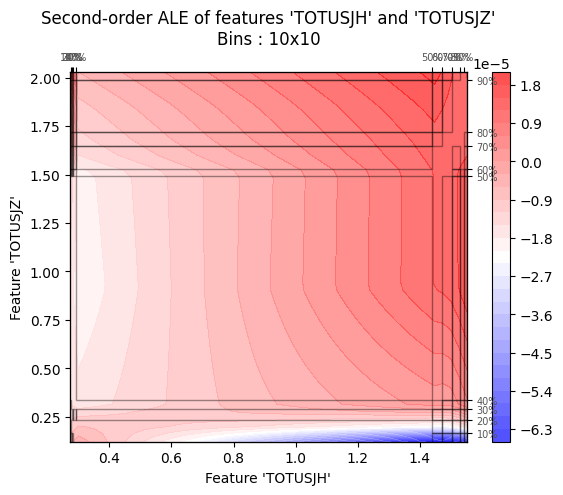

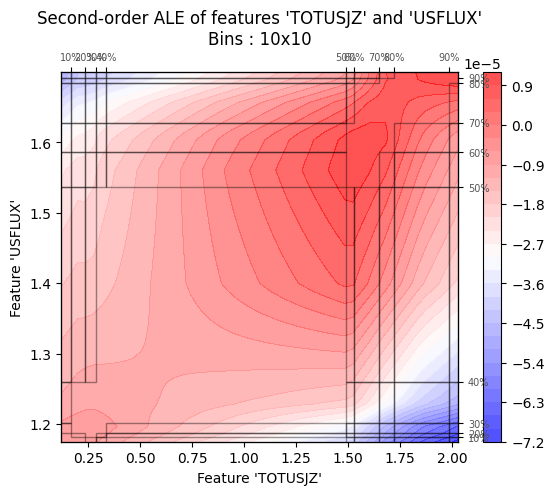

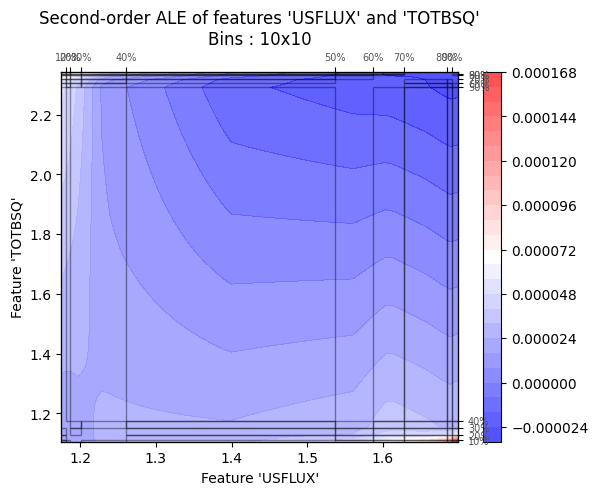

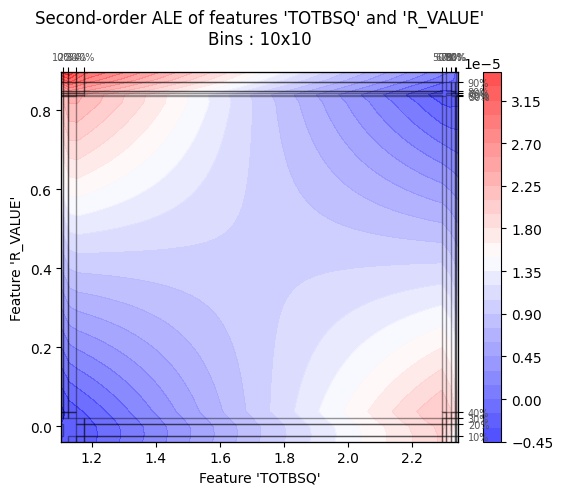

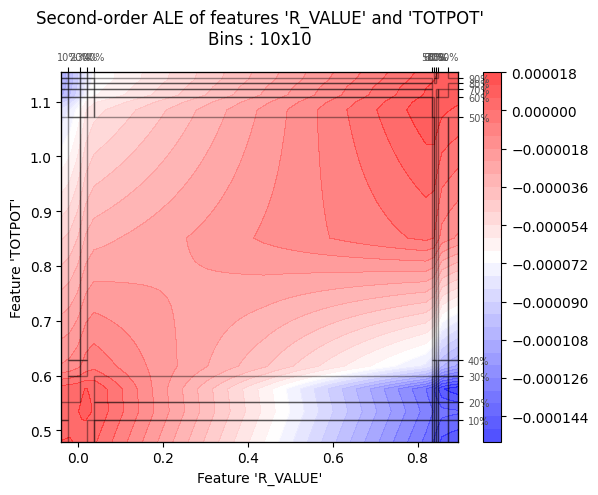

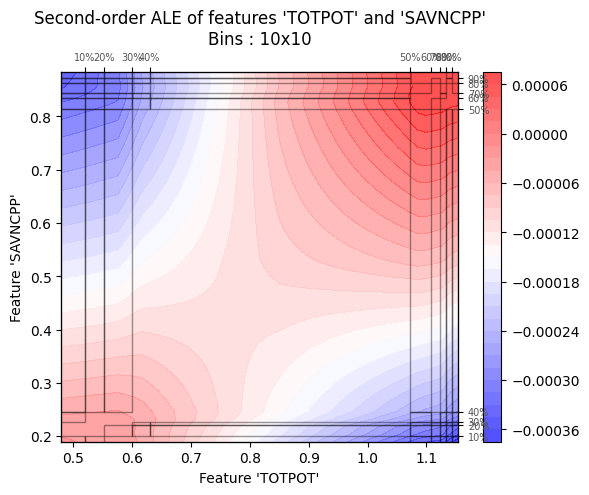

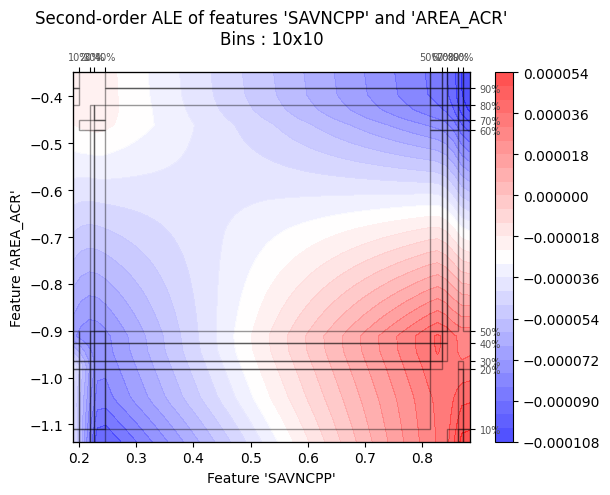

<Figure size 1400x1000 with 0 Axes>

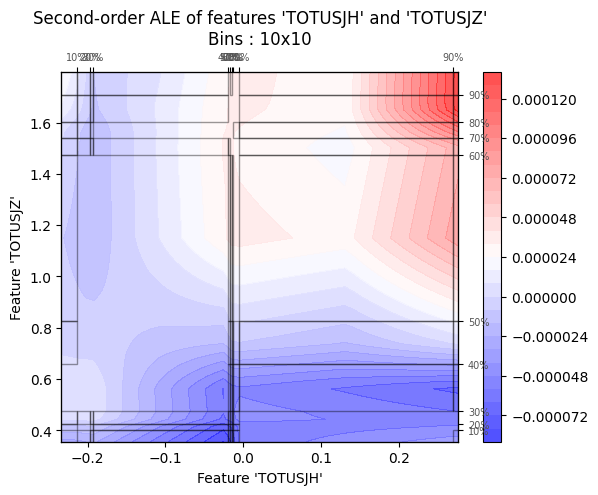

KeyboardInterrupt: 

In [4]:
#Test existing models for SolarFlareNet C,M, and M5 flares for  24, 47, and 72 hours.
#You change the values to limit the flare types and number of hours to test.

from lime.lime_tabular import RecurrentTabularExplainer
import shap
from shap import DeepExplainer
import timeshap
from timeshap.explainer import local_pruning, local_event, local_feat, local_cell_level
from timeshap.plot import plot_temp_coalition_pruning, plot_event_heatmap, plot_feat_barplot, plot_cell_level
from alibi.explainers import KernelShap
from alibi.explainers import ALE, plot_ale
from alepython import ale_plot
import matplotlib.pyplot as plt


interpretable_tools = {"LIM":[50], "ALE":None, "SHA":3}
tool_fn = lambda x: print("Interpreting using %s method" %x)

for time_window in Window:
    for flare_class in Class:
        model, train_data, test_data = test(str(time_window), flare_class)
        #model.summary()
        log('===========================================================\n\n',verbose=True)
        for tool in interpretable_tools:
            if tool == "LIME":
                tool_fn(tool)
                model_mask = model.get_model()
                explainer = RecurrentTabularExplainer(train_data[0], training_labels=train_data[1], feature_names=feature_names,
                                                    discretize_continuous=True, verbose=True, feature_selection='highest_weights',
                                                    class_names=['Negative', 'Positive'], discretizer='decile')
                instance = interpretable_tools["LIME"]
                for i in instance:
                        exp = explainer.explain_instance(test_data[0][i], model_mask.predict, num_features=len(feature_names), num_samples=5000)
                        exp.show_in_notebook()
                        exp.as_pyplot_figure()
                        #exp.save_to_file(file_path="interpret/%s_%d.html" %(flare_class,time_window))
            elif tool == "SHAP":
                tool_fn(tool)
                model_mask = model.get_model()
                instance = interpretable_tools["SHAP"]

                explainer = DeepExplainer(model_mask, train_data[0])
                shap_values = explainer.shap_values(test_data[0][(instance-1):instance], check_additivity=False)
                expected_value = explainer.expected_value
                shap.plots.initjs()
                display(shap.decision_plot(expected_value[0], shap_values[0][0], feature_names))
                display(shap.force_plot(expected_value[0], shap_values[0][0], feature_names=feature_names, 
                                        matplotlib=True, contribution_threshold=0.005))
                
                """predict_fn = lambda x: model.predict(x)
                explainer = KernelShap(predict_fn, link='logit', feature_names=feature_names)
                explainer.fit(np.squeeze(train_data[0][:5000]))
                explanation = explainer.explain(np.squeeze(test_data[0])[(instance-1):instance])"""
            elif tool == "ALE":
                tool_fn(tool)
                ale = ALE(model.predict, feature_names=feature_names, target_names=["label"])
                #ale_exp = ale.explain(np.squeeze(train_data[0])[:50000], min_bin_points=20)
                #plot_ale(ale_exp, n_cols=3, fig_kw={'figwidth':14, 'figheight': 10})
                """for feature in feature_names:
                    plot_ale(ale_exp, features=[feature])"""
                #plt.rc("figure", figsize=(9, 6))
                #plt.subplots(figsize=(9, 6))
                X_train_df = pd.DataFrame(np.squeeze(train_data[0])[:50], columns=feature_names)
                #ale_plot(model, X_train_df, [feature_names[0], feature_names[1]], bins=10, monte_carlo=True)
                fig = plt.figure(figsize=(14, 10))
                fig.subplots_adjust(hspace=0.4, wspace=0.4)
                for i in range(len(feature_names)):
                    for j in range(len(feature_names)):
                        if j-i == 2:
                            f1 = feature_names[i]
                            f2 = feature_names[j-1]
                            ax = ale_plot(model, X_train_df, features=[f1,f2], bins=10)
                            f = ax.get_figure()
                            print(ax.get_images())
                            print(f.get_axes())
                            #plt.axes(ax)
                            
                """mpl.rc("figure", figsize=(9, 6))
                for f1 in feature_names:
                    for f2 in feature_names:
                        if f1 != f2:
                            ale_plot(model, X_train_df, features=[f1, f2], bins=10, monte_carlo=True)"""
                
                
                